In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import numpy as np

from arch.fnet import DCNN, Reshape, DCNN_3
from arch.ADMM_net import ADMM_net_2D, ADMM_net_2
from arch.GAP_net import  GAP_net_2
from arch.NoiseLayer import NoiseLayer
from load_config_noarg import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [3]:
y = torch.rand(10,121)
Phi = torch.rand(9,121)

# net = ADMM_net_2(121)
net = GAP_net_2(121,9)
noiselayer = NoiseLayer(100,0)

In [4]:
import scipy.io as sio
phi = sio.loadmat(r'nets\hybnet\20231212_143545\TargetCurves.mat')['TargetCurves']
phi = torch.from_numpy(phi).float().to(device_train)

In [5]:

import math
import tqdm

LossFcn = nn.MSELoss()

EpochNum = 301

optimizer_net = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
scheduler_net = torch.optim.lr_scheduler.StepLR(optimizer_net, step_size=lr_decay_step, gamma=lr_decay_gamma) 

loss = torch.tensor([0], device=device_train)
loss_train = torch.zeros(math.ceil(EpochNum / TestInterval))
loss_test = torch.zeros(math.ceil(EpochNum / TestInterval))
net.to(device_train)


GAP_net_2(
  (net0): MyModel(
    (fc1): Linear(in_features=121, out_features=150, bias=True)
    (fc2): Linear(in_features=150, out_features=150, bias=True)
    (fc3): Linear(in_features=150, out_features=150, bias=True)
    (fc4): Linear(in_features=150, out_features=150, bias=True)
    (fc5): Linear(in_features=150, out_features=121, bias=True)
  )
  (net1): MyModel(
    (fc1): Linear(in_features=121, out_features=150, bias=True)
    (fc2): Linear(in_features=150, out_features=150, bias=True)
    (fc3): Linear(in_features=150, out_features=150, bias=True)
    (fc4): Linear(in_features=150, out_features=150, bias=True)
    (fc5): Linear(in_features=150, out_features=121, bias=True)
  )
  (net2): MyModel(
    (fc1): Linear(in_features=121, out_features=150, bias=True)
    (fc2): Linear(in_features=150, out_features=150, bias=True)
    (fc3): Linear(in_features=150, out_features=150, bias=True)
    (fc4): Linear(in_features=150, out_features=150, bias=True)
    (fc5): Linear(in_feature

In [6]:
# Train HybNet
for epoch in tqdm.tqdm(range(EpochNum)):
    # Shuffle training data
    Specs_train = Specs_train[torch.randperm(TrainingDataSize), :]
    for i in range(0, TrainingDataSize // BatchSize):
        
        # Get batch of training data
        Specs_batch = Specs_train[i * BatchSize: i * BatchSize + BatchSize, :].to(device_train)
        # sampled = torch.matmul(Specs_batch, phi.T).to(device_train)
        sampled = Specs_batch.unsqueeze(-1) 
        # sampled = noiselayer(sampled)
        # Forward pass through HybNet
        Output_pred = net(sampled, torch.rand(16,121).to(device_train)).sum(dim=2)
        # Calculate loss and backpropagate
        loss = LossFcn(Specs_batch, Output_pred)
        optimizer_net.zero_grad()
        loss.backward(retain_graph=True)
        optimizer_net.step()
    scheduler_net.step()
    if epoch % TestInterval == 0:
        loss_train[epoch // TestInterval] = loss.data
        net.eval()
        # Test HybNet
        for i in range(0, TestingDataSize // BatchSize):
            # Get batch of testing data
            Specs_batch = Specs_test[i * BatchSize: i * BatchSize + BatchSize, :].to(device_train)
            # sampled = torch.matmul(Specs_batch, phi.T).to(device_train)
            sampled = Specs_batch.unsqueeze(-1)
            # sampled = noiselayer(sampled)
            # Forward pass through HybNet
            Output_pred = net(sampled, torch.rand(16,121).to(device_train)).sum(dim=2)
            # Calculate loss
            loss = LossFcn(Specs_batch, Output_pred)
        loss_test[epoch // TestInterval] = loss.data
        net.train()


 65%|██████▌   | 196/301 [17:15<10:01,  5.73s/it]

In [1]:
import matplotlib.pyplot as plt
loss_train = loss_train.cpu().numpy()
loss_test = loss_test.cpu().numpy()
plt.plot(loss_train, label='train')
plt.plot(loss_test, label='test')
plt.legend()
plt.show()

NameError: name 'loss_train' is not defined

In [ ]:
loss_test.min(),loss_test[-1]

NameError: name 'loss_test' is not defined

In [ ]:
# torch.save(net, r'nets\ADMM_net\20240123\admm_net.pth')

In [ ]:
Output_pred = Output_pred.cpu().detach().numpy()
Specs_batch = Specs_batch.cpu().detach().numpy()

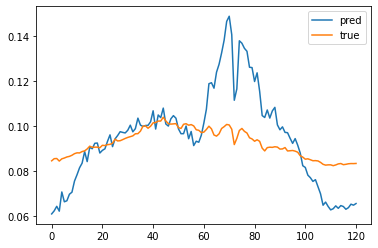

In [ ]:
idx = 185
plt.plot(Output_pred[idx,:], label='pred')
plt.plot(Specs_batch[idx,:], label='true')
plt.legend()


In [193]:
Phi = torch.rand(9,20) *200
torch.var(torch.sum(Phi, dim=1)/torch.sum(Phi, dim=1).max())

tensor(0.0094)